In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import sem, t
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

# NonLin Corr Plots

In [22]:
def hp_corr_plots(one_file, two_file, three_file, four_file, true_file):
    #one = np.load(one_file)[:,:730]
    two = np.load(two_file)
    three = np.load(three_file)
    four = np.load(four_file)
    true = np.load(true_file)
    
    corr_array = np.empty((true.shape[1],2))
    
    for i in tnrange(true.shape[1]):
        #corr_array[i,0] = np.corrcoef(true[:,i] , one[:,i])[0][1]
        corr_array[i,0] = np.corrcoef(true[:,i] , two[:,i])[0][1]
        #corr_array[i,2] = np.corrcoef(true[:,i] , three[:,i])[0][1]
        corr_array[i,1] = np.corrcoef(true[:,i] , four[:,i])[0][1]
        
    mean_array = np.mean(corr_array,axis=0)
    print(mean_array.shape)
    
    std_err = np.empty((corr_array.shape[1],))
    confidence = 0.99
    for i in range(std_err.shape[0]):
        std_err[i] = sem(corr_array[:,i]) * t.ppf((1 + confidence) / 2, corr_array[:,i].shape[0] - 1)
        
    fig, axs = plt.subplots(figsize = (9,6))
    
    bar_names = ["Full Linear HP", "Full NN HP", "Part NN HP",]
    
    part_corr_array = np.empty((three.shape[1]))
    
    for i in tnrange(three.shape[1]):
        part_corr_array[i] = np.corrcoef(true[:,i], three[:,i])[0][1]
    
    part_std_err = sem(part_corr_array) * t.ppf((1 + confidence) / 2, corr_array.shape[0] - 1)

    mean_array = np.append(mean_array, np.mean(part_corr_array))
    std_err = np.append(std_err, part_std_err)
    
    plt.bar(np.arange(mean_array.shape[0]), mean_array, yerr=std_err, tick_label = bar_names)  
    plt.title("HP Decoded Test Corr Comparison +/- 99% CI")
    plt.ylim(0.20,0.40)


(2,)


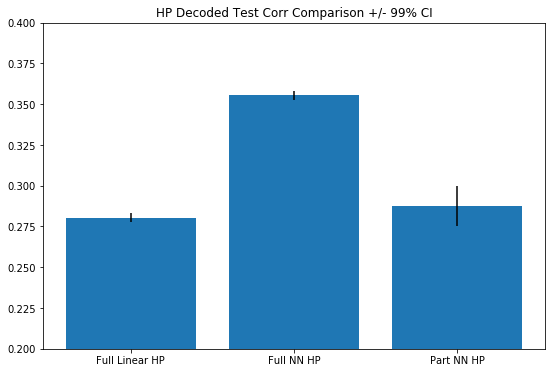

In [23]:
one_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_part_hp_test_decoded.npy"
two_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_ridge_hp_test_decoded.npy"
three_file = "/ssd/joon/2017_11_29_ns/yass/decoded/hp_part_nn_f10_h40_0.025_w5e6.npy"
four_file = "/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy"
true_file = "/ssd/joon/2017_11_29_ns/images/hp_test_images.npy"



hp_corr_plots(one_file, two_file, three_file, four_file, true_file)

# HP Decoding Plots

In [11]:
def hp_decode_plot(one_img, two_img, three_img, index):
    fig, axs = plt.subplots(ncols = 3, figsize = (10,4))
    
    axs[0].imshow(one_img.reshape((95,146)))
    axs[1].imshow(two_img.reshape((95,146)))
    axs[2].imshow(three_img.reshape((95,146)))
    
    axs[0].axis("off")
    axs[1].axis("off")
    axs[2].axis("off")
    
    lin_corr = np.corrcoef(one_img, two_img)[0][1]
    nn_corr = np.corrcoef(one_img, three_img)[0][1]
    
    axs[0].set_title("Img "+str(index)+": True HP")
    axs[1].set_title("Img "+str(index)+": Linear HP (" +str(round(lin_corr, 4))+")")
    axs[2].set_title("Img "+str(index)+": NeuralNet HP ("+str(round(nn_corr, 4))+")")
    
    lin_corr = np.corrcoef(one_img, two_img)[0][1]
    nn_corr = np.corrcoef(one_img, three_img)[0][1]
    
    fig.tight_layout()

def multi_hp_decode_plots(one_file, two_file, three_file, plot_no, save_dir):
    ones = np.load(one_file)
    twos = np.load(two_file)
    threes = np.load(three_file)
    
    with PdfPages(os.path.join(save_dir, "hp_nonlinear_comparison.pdf")) as pdf:
        for i in tnrange(0,plot_no):
            
            one_img = ones[i,:]
            two_img = twos[i,:]
            three_img = threes[i,:]
            
            fig = hp_decode_plot(one_img, two_img, three_img, i)
            pdf.savefig(fig)
            plt.close()

In [12]:
one_file = "/ssd/joon/2017_11_29_ns/images/hp_test_images.npy"
two_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_ridge_hp_test_decoded.npy"
three_file = "/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"
plot_no = 100

multi_hp_decode_plots(one_file, two_file, three_file, plot_no, save_dir)

# Full Img Decoding Plots

In [13]:
def indiv_full_img_plot(true_img, smooth_dec, hp_dec, index):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
    
    decoded_min = min(np.min(true_img), np.min(smooth_dec), np.min(hp_dec))
    decoded_max = max(np.max(true_img), np.max(smooth_dec), np.max(hp_dec))
    resid_min = min(np.min(true_img - smooth_dec), np.min(true_img - smooth_dec - hp_dec))
    resid_max = max(np.max(true_img - smooth_dec), np.max(true_img - smooth_dec - hp_dec))
    
    axs[0,0].imshow(true_img.reshape((95,146)), vmin=decoded_min, vmax=decoded_max)
    axs[0,1].imshow(smooth_dec.reshape((95,146)), vmin=decoded_min, vmax=decoded_max)
    axs[0,2].imshow(hp_dec.reshape((95,146)) + smooth_dec.reshape((95,146)), vmin=decoded_min, vmax=decoded_max)
    
    axs[1,1].imshow(true_img.reshape((95,146)) - smooth_dec.reshape((95,146)),
                   vmin=resid_min, vmax=resid_max)
    axs[1,2].imshow(true_img.reshape((95,146)) - smooth_dec.reshape((95,146)) - hp_dec.reshape((95,146)),
                   vmin=resid_min, vmax=resid_max)
    
    smooth_corr = np.corrcoef(true_img, smooth_dec)[0][1]
    comb_corr = np.corrcoef(true_img, smooth_dec+hp_dec)[0][1]
    
    axs[0,0].axis("off")
    axs[0,1].axis("off")
    axs[0,2].axis("off")
    axs[1,0].axis("off")
    axs[1,1].axis("off")
    axs[1,2].axis("off")
    
    axs[0,0].set_title("Img " +str(index)+": True")
    axs[0,1].set_title("Smooth_Dec (" +str(round(smooth_corr, 4))+")")
    axs[0,2].set_title("Smooth_Dec + HP_Dec ("+str(round(comb_corr, 4))+")")
    axs[1,1].set_title("True - Smooth_Dec")
    axs[1,2].set_title("True - (Smooth_Dec + HP_Dec)")
    
    
    fig.tight_layout()
    
def multi_full_img_plots(true_file, smooth_file, hp_file, plot_no, save_dir):
    true = np.load(true_file)
    smooth = np.load(smooth_file)
    hp = np.load(hp_file)
    
    with PdfPages(os.path.join(save_dir, "full_decoded_comparison.pdf")) as pdf:
        for i in tnrange(0,plot_no):
            
            true_img = true[i,:]
            smooth_dec = smooth[i,:]
            hp_dec = hp[i,:]
            
            fig = indiv_full_img_plot(true_img, smooth_dec, hp_dec, i)
            pdf.savefig(fig)
            plt.close()
    
    

In [14]:
true_file = "/ssd/joon/2017_11_29_ns/images/test_images.npy"
smooth_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
hp_file = "/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"
plot_no = 100





multi_full_img_plots(true_file, smooth_file, hp_file, plot_no, save_dir)

# Full Img, COmbined Decoded Test Corr


[0.88710865 0.89980141]


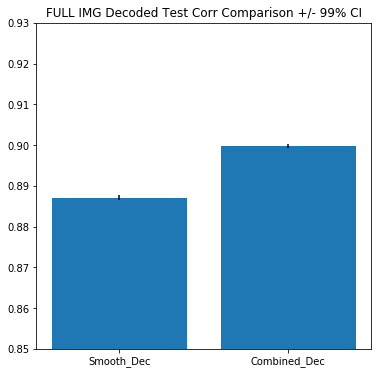

In [30]:
true = np.load("/ssd/joon/2017_11_29_ns/images/test_images.npy")
smooth = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy")
hp = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy")
combined = smooth + hp

corr_array = np.empty((true.shape[1],2))

for i in tnrange(true.shape[1]):
    corr_array[i,0] = np.corrcoef(true[:,i], smooth[:,i])[0][1]
    corr_array[i,1] = np.corrcoef(true[:,i], combined[:,i])[0][1]
    
mean_array = np.mean(corr_array, axis=0)

std_err = np.empty((corr_array.shape[1]))
confidence = 0.99

for i in range(std_err.shape[0]):
    std_err[i] = sem(corr_array[:,i]) * t.ppf((1 + confidence) / 2, corr_array[:,i].shape[0] - 1)

fig, axs = plt.subplots(figsize = (6,4))
    
bar_names = ["Smooth_Dec", "Combined_Dec"]
plt.bar(np.arange(mean_array.shape[0]), mean_array, yerr=std_err, tick_label = bar_names)  
plt.title("FULL IMG Decoded Test Corr Comparison +/- 99% CI")
plt.ylim(0.85,0.93)

print(mean_array)

Text(0, 0.5, 'Smooth Decoded R')

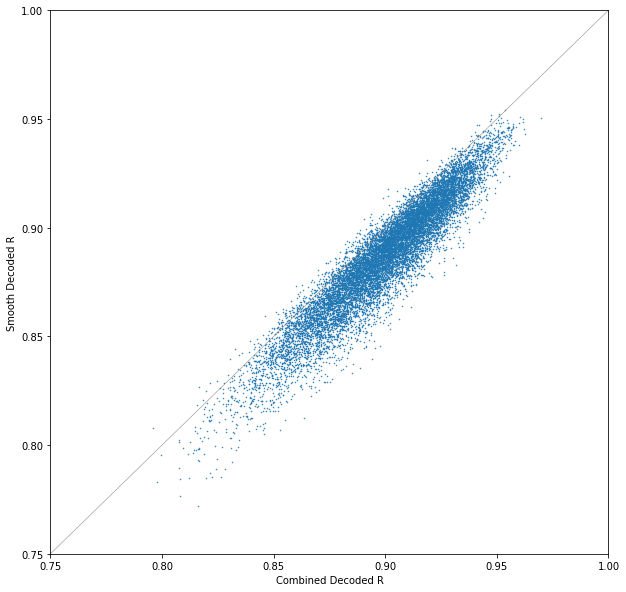

In [12]:
true = np.load("/ssd/joon/2017_11_29_ns/images/test_images.npy")
smooth = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy")
hp = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy")
combined = smooth + hp

corr_array = np.empty((true.shape[1],2))

for i in tnrange(true.shape[1]):
    corr_array[i,0] = np.corrcoef(true[:,i], smooth[:,i])[0][1]
    corr_array[i,1] = np.corrcoef(true[:,i], combined[:,i])[0][1]
    
plt.figure(figsize=(10,10))
    
plt.scatter(corr_array[:,1], corr_array[:,0], s=0.24)
plt.plot(np.arange(0,1.01,0.1), np.arange(0,1.01,0.1), ls="-", lw=0.5, c="gray")
plt.ylim(0.75,1)
plt.xlim(0.75,1)
plt.xlabel("Combined Decoded R")
plt.ylabel("Smooth Decoded R")


# Per-Pixel Corr Hotspots

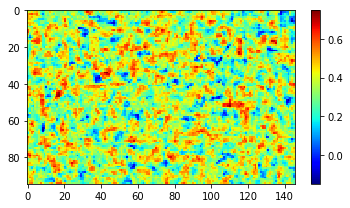

In [10]:
hp_dec = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy")
hp_true = np.load("/ssd/joon/2017_11_29_ns/images/hp_test_images.npy")

corr_array = np.empty((hp_dec.shape[1]))

for i in tnrange(hp_dec.shape[1]):
    corr = np.corrcoef(hp_dec[:,i], hp_true[:,i])[0][1]
    corr_array[i] = corr
    
plt.imshow(corr_array.reshape((95,146)), cmap="jet")
plt.colorbar(shrink=0.8)

# Smooth LP Corr vs Comb LP Corr Scatter Plots

Text(0, 0.5, 'LP-Smooth_Dec Corr')

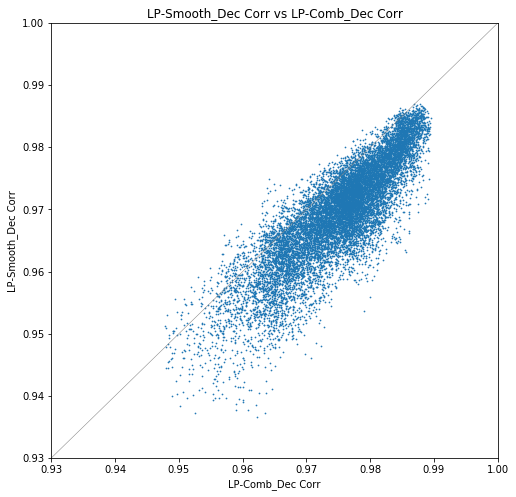

In [9]:
smooth = np.load("/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy")
smooth_dec = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy")
hp_dec = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy")
comb_dec = smooth_dec + hp_dec

smooth_corr = np.empty((smooth.shape[1]))
comb_corr = np.empty((smooth.shape[1]))

for i in tnrange(smooth.shape[1]):
    smooth_corr[i] = np.corrcoef(smooth[:,i], smooth_dec[:,i])[0][1]
    comb_corr[i] = np.corrcoef(smooth[:,i], comb_dec[:,i])[0][1]

plt.figure(figsize = (8,8))
plt.scatter(smooth_corr, comb_corr, s=0.5)
plt.plot(np.arange(0,1.01,0.1), np.arange(0,1.01,0.1), c="gray", ls="-", lw=0.5)
plt.xlim(0.93,1)
plt.ylim(0.93,1)
plt.title("LP-Smooth_Dec Corr vs LP-Comb_Dec Corr")
plt.xlabel("LP-Comb_Dec Corr")
plt.ylabel("LP-Smooth_Dec Corr")

# Residuals: LP-Smooth_Dec vs LP-Comb_Dec

In [14]:
def lp_residuals_plot(smooth, smooth_dec, hp_dec, index):
    comb_dec = smooth+hp_dec
    smooth_resid = smooth - smooth_dec
    comb_resid = smooth - comb_dec
    
    fig, axs = plt.subplots(nrows = 2, ncols=3, figsize = (10,6))
    
    dec_min = min(np.min(smooth), np.min(smooth_dec), np.min(comb_dec))
    dec_max = max(np.max(smooth), np.max(smooth_dec), np.max(comb_dec))
    resid_min = min(np.min(smooth_resid), np.min(comb_resid))
    resid_max = min(np.max(smooth_resid), np.max(comb_resid))
    
    axs[0,0].imshow(smooth.reshape((95,146)), vmin=dec_min, vmax=dec_max)
    axs[0,1].imshow(smooth_dec.reshape((95,146)), vmin=dec_min, vmax=dec_max)
    axs[0,2].imshow(comb_dec.reshape((95,146)), vmin=dec_min, vmax=dec_max)
    axs[1,1].imshow(smooth_resid.reshape((95,146)), vmin=resid_min, vmax=resid_max)
    axs[1,2].imshow(comb_resid.reshape((95,146)), vmin=resid_min, vmax=resid_max)
    
    smooth_corr = np.corrcoef(smooth, smooth_dec)[0][1]
    comb_corr = np.corrcoef(comb_dec, smooth)[0][1]
    
    axs[0,0].axis("off")
    axs[0,1].axis("off")
    axs[0,2].axis("off")
    axs[1,0].axis("off")
    axs[1,1].axis("off")
    axs[1,2].axis("off")
    
    axs[0,0].set_title("Img " +str(index)+": LP True")
    axs[0,1].set_title("Smooth_Dec (" +str(round(smooth_corr, 4))+")")
    axs[0,2].set_title("Smooth_Dec + HP_Dec ("+str(round(comb_corr, 4))+")")
    axs[1,1].set_title("LP True - Smooth_Dec")
    axs[1,2].set_title("LP True - (Smooth_Dec + HP_Dec)")
    
    fig.tight_layout()

def multi_lp_residuals_plot(smooth_file, smooth_dec_file, hp_dec_file, plot_no, save_dir):
    smooth_imgs = np.load("/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy")
    smooth_dec_imgs = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy")
    hp_dec_imgs = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy")

    with PdfPages(os.path.join(save_dir, "lp_residuals_comparison.pdf")) as pdf:
        for i in tnrange(0,plot_no):
            
            smooth = smooth_imgs[i,:]
            smooth_dec = smooth_dec_imgs[i,:]
            hp_dec = hp_dec_imgs[i,:]
            
            fig = lp_residuals_plot(smooth, smooth_dec, hp_dec, i)
            pdf.savefig(fig)
            plt.close()


In [15]:
smooth_file = "/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy"
smooth_dec_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
hp_dec_file = "/ssd/joon/2017_11_29_ns/yass/decoded/hp_FULL_f10_h40_0.5_w5e6.npy"
plot_no = 100
save_dir = "/ssd/joon/2017_11_29_ns/figures/"



multi_lp_residuals_plot(smooth_file, smooth_dec_file, hp_dec_file, plot_no, save_dir)